## Trial Run: Predicting with Keras 




### Load the required libraries

In [1]:
import tensorflow as tf
# import tensorflowvisu
import math
import pandas as pd
import numpy as np
import glob
from sklearn import preprocessing
# Set charts to view inline
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
import numpy
from numpy import concatenate


Using TensorFlow backend.


In [2]:
# DATA698  Crypto Project
# market_data.py
#This file pulls the historical market data from cryptocompare.com

import sys
import requests
import datetime
import pandas as pd
import matplotlib.pyplot as plt

def arg_check():
    if len(arg) != 3:
        print ("Usage: Crypto BaseCurrency candle_size")

def minute_price_historical(symbol, comparison_symbol, limit, aggregate, exchange=''):
    url = 'https://min-api.cryptocompare.com/data/histominute?fsym={}&tsym={}&limit={}&aggregate={}'\
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate)
    if exchange:
        url += '&e={}'.format(exchange)
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in df.time]
    return df


def writecsv(df, filename):
    df.to_csv(filename)
    print(filename, "saved")


def main():
    minute = minute_price_historical('BTC', 'USD', 50, 1)
    writecsv(minute, './data/BTC_minute.csv')
    
if  __name__ =='__main__':
    main()

./data/BTC_minute.csv saved


In [3]:
df = pd.read_csv("./data/BTC_minute.csv",usecols=['timestamp','close'])

In [4]:
df.head()

,close,timestamp
0,10336.32,2018-02-28 20:15:00
1,10348.38,2018-02-28 20:16:00
2,10352.68,2018-02-28 20:17:00
3,10347.05,2018-02-28 20:18:00
4,10365.66,2018-02-28 20:19:00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 2 columns):
close        51 non-null float64
timestamp    51 non-null object
dtypes: float64(1), object(1)
memory usage: 896.0+ bytes


In [6]:

df['timestamp'] = pd.to_datetime(df['timestamp'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 2 columns):
close        51 non-null float64
timestamp    51 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 896.0 bytes


In [8]:
df.index = df['timestamp']

In [9]:
# Taking the historical price alone
series = Series(df.drop('timestamp',axis=1)['close'])

In [10]:


# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df = df.drop(0)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# run a repeated experiment
def experiment(repeats, series):
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, 1)
	supervised_values = supervised.values
	# split data into train and test-sets
	train, test = supervised_values[0:-12], supervised_values[-12:]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(repeats):
		# fit the base model
		lstm_model = fit_lstm(train_scaled, 1, 500, 1)
		# forecast test dataset
		predictions = list()
		for i in range(len(test_scaled)):
			# predict
			X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
			yhat = forecast_lstm(lstm_model, 1, X)
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		error_scores.append(rmse)
	return error_scores

# execute the experiment
def run(series):
	# load dataset
	
	# experiment
	repeats = 10
	results = DataFrame()
	# run experiment
	results['results'] = experiment(repeats, series)
	# summarize results
	print(results.describe())
	# save results
	results.to_csv('experiment_fixed.csv', index=False)

 # entry point
run(series)

1) Test RMSE: 9.023
2) Test RMSE: 8.957
3) Test RMSE: 9.398
4) Test RMSE: 8.541
5) Test RMSE: 9.351
6) Test RMSE: 8.980
7) Test RMSE: 9.395
8) Test RMSE: 9.284
9) Test RMSE: 9.684
10) Test RMSE: 9.999
         results
count  10.000000
mean    9.261156
std     0.410378
min     8.540828
25%     8.990645
50%     9.317761
75%     9.397198
max     9.998967


In [ ]:
# Manualexecution - Not required to run 

#raw_values = series.values
#diff_values = difference(raw_values, 1)
## transform data to be supervised learning
#supervised = timeseries_to_supervised(diff_values, 1)
#supervised_values = supervised.values
## split data into train and test-sets
#train, test = supervised_values[0:-12], supervised_values[-12:]
## transform the scale of the data
#scaler, train_scaled, test_scaled = scale(train, test)
#
#raw_values = df.values
#
#diff = list()
#interval=1
#for i in range(interval, len(raw_values)):
#    value = raw_values[i] - raw_values[i - interval]
#    diff.append(value)

In [11]:
## Type II with live LSTM update

In [12]:
# Update LSTM model
def update_model(model, train, batch_size, updates):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	for i in range(updates):
		model.fit(X, y, nb_epoch=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()

# run a repeated experiment
def experiment(repeats, series, updates):
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, 1)
	supervised_values = supervised.values
	# split data into train and test-sets
	train, test = supervised_values[0:-12], supervised_values[-12:]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(repeats):
		# fit the base model
		lstm_model = fit_lstm(train_scaled, 1, 500, 1)
		# forecast test dataset
		train_copy = numpy.copy(train_scaled)
		predictions = list()
		for i in range(len(test_scaled)):
			# update model
			if i > 0:
				update_model(lstm_model, train_copy, 1, updates)
			# predict
			X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
			yhat = forecast_lstm(lstm_model, 1, X)
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
			# add to training set
			train_copy = concatenate((train_copy, test_scaled[i,:].reshape(1, -1)))
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		error_scores.append(rmse)
	return error_scores

# execute the experiment
def run(series):
	# load dataset
	# experiment
	repeats = 10
	results = DataFrame()
	# run experiment
	updates = 2
	results['results'] = experiment(repeats, series, updates)
	# summarize results
	print(results.describe())
	# save results
	results.to_csv('experiment_update_2.csv', index=False)

 # entry point
run(series)

C:\ProgramData\Anaconda3\lib\site-packages\keras\models.py:874: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


1) Test RMSE: 9.258
2) Test RMSE: 8.713
3) Test RMSE: 9.270
4) Test RMSE: 9.463
5) Test RMSE: 8.888
6) Test RMSE: 9.308
7) Test RMSE: 9.103
8) Test RMSE: 9.084
9) Test RMSE: 9.224
10) Test RMSE: 8.904
         results
count  10.000000
mean    9.121485
std     0.229176
min     8.713118
25%     8.948854
50%     9.163672
75%     9.266605
max     9.462885


In [ ]:
# Below is the code from Tom - Have Not changed anything. 

In [32]:
df.head()

,close,high,low,open,volumefrom,volumeto,timestamp
0,10562.57,10562.97,10558.17,10558.51,28.58,306370.40,2018-02-27 10:48:00
1,10580.74,10580.74,10561.70,10562.57,103.72,1099199.53,2018-02-27 10:49:00
2,10605.10,10605.43,10581.48,10581.48,203.78,2161443.14,2018-02-27 10:50:00
3,10597.01,10608.20,10596.96,10605.27,101.19,1074229.06,2018-02-27 10:51:00
4,10597.47,10598.43,10592.95,10597.02,43.28,464134.86,2018-02-27 10:52:00


### Make Model II
Following Dashee at https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-11-20-predicting-cryptocurrency-prices-with-deep-learning.ipynb

In [31]:
newdf.head()

,diff,trans,volatil,bidask,price,volume,transpm,score
2016-02-25,1.634920e+11,216290,0.877869,0.395403,422.833398,2.414980e+07,295.393889,0.063306
2016-02-26,1.634920e+11,203635,0.564052,0.359820,423.847443,3.032645e+07,270.019722,0.106433
2016-02-27,1.634920e+11,182177,0.471312,0.397194,431.913038,1.763800e+08,227.732431,0.056521
2016-02-28,1.634920e+11,233436,0.668662,0.411491,428.947530,1.354377e+08,259.078542,0.047878
2016-02-29,1.634920e+11,265320,0.936643,0.476494,436.160354,4.114757e+08,377.598750,0.139419


In [32]:
newdf['date'] = newdf.index

In [36]:
# to find columns for normalizing
# looks like diff, trans, volatil, transpm
newdf.describe()

,diff,trans,volatil,bidask,price,volume,transpm,Unnamed: 0,score
count,7.260000e+02,726.000000,726.000000,726.000000,726.000000,7.260000e+02,726.000000,725.000000,725.000000
mean,6.792756e+11,259070.951791,15.291298,0.566330,3045.026655,3.447175e+08,186.330182,1629.638574,0.124207
std,6.385959e+11,53047.562734,29.986647,0.300516,4045.445824,6.378220e+08,190.848958,509.177960,0.083190
min,1.584270e+11,131875.000000,0.309804,0.122368,403.525223,7.692798e+06,6.829306,5.605042,-0.356950
25%,2.173750e+11,221229.250000,1.067595,0.337099,632.014072,2.570754e+07,33.351367,1422.133333,0.078024
50%,4.407800e+11,250547.500000,2.859097,0.487276,1041.254032,6.832120e+07,121.583102,1702.777778,0.120534
75%,9.227250e+11,292452.750000,13.514089,0.761837,3902.613667,3.068351e+08,284.370278,1951.132743,0.165040
max,2.874670e+12,490644.000000,299.185609,1.575526,19389.505010,5.457602e+09,1060.248333,2879.862069,0.539618


In [37]:
# split date separates test, training rows
# window_len is the 10 day window to predict on
# norm_cols is the columns we'll normalize so keras doesn't choke
split_date = '2017-06-01'
window_len = 10
norm_cols = ['trans','volatil', 'transpm']

In [38]:
# create the training, test sets
# we don't need the date columns anymore
training_set, test_set = newdf[newdf['date']<split_date], newdf[newdf['date']>=split_date]
training_set = training_set.drop('date', 1)
test_set = test_set.drop('date', 1)

In [39]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 298 entries, 2016-02-25 to 2018-02-19
Data columns (total 9 columns):
diff          298 non-null float64
trans         298 non-null int64
volatil       298 non-null float64
bidask        298 non-null float64
price         298 non-null float64
volume        298 non-null float64
transpm       298 non-null float64
Unnamed: 0    298 non-null float64
score         298 non-null float64
dtypes: float64(8), int64(1)
memory usage: 23.3 KB


In [40]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 428 entries, 2016-03-01 to 2017-09-30
Data columns (total 9 columns):
diff          428 non-null float64
trans         428 non-null int64
volatil       428 non-null float64
bidask        428 non-null float64
price         428 non-null float64
volume        428 non-null float64
transpm       428 non-null float64
Unnamed: 0    427 non-null float64
score         427 non-null float64
dtypes: float64(8), int64(1)
memory usage: 33.4 KB


In [41]:
# creates 10-day windows for predicting 
# this is a list of 10-row arrays
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['price'][window_len:].values/training_set['price'][:-window_len].values)-1

In [47]:
# second window in list
LSTM_training_inputs[2]

,diff,trans,volatil,bidask,price,volume,transpm,Unnamed: 0,score
2016-02-27,1.634920e+11,0.000000,0.000000,0.397194,431.913038,1.763800e+08,0.000000,2201.928571,0.056521
2016-02-28,1.634920e+11,0.281369,0.418724,0.411491,428.947530,1.354377e+08,0.137644,1931.333333,0.047878
2016-02-29,1.634920e+11,0.456386,0.987309,0.476494,436.160354,4.114757e+08,0.658081,2039.857143,0.139419
2016-10-01,2.412270e+11,0.174298,0.155936,0.402101,614.344305,1.001525e+07,-0.094613,908.714286,0.000943
2016-10-02,2.412270e+11,0.057669,1.947955,0.324478,612.972535,1.002323e+07,-0.333671,1123.333333,0.246733
2016-10-03,2.412270e+11,0.420624,1.531651,0.284711,612.503563,1.365115e+07,-0.429370,1516.800000,0.302850
2016-10-04,2.412270e+11,0.452774,0.337947,0.261954,611.004079,1.488683e+07,-0.439810,1230.187500,0.027563
2016-10-05,2.412270e+11,0.464570,6.612755,0.355315,612.884502,1.333096e+07,-0.338516,1334.250000,-0.096500
2016-10-06,2.412270e+11,0.506700,2.987196,0.430859,613.286756,1.283950e+07,-0.514663,1224.290323,0.255348
2016-10-07,2.412270e+11,0.461897,2.006687,0.376334,615.884071,1.874079e+07,-0.286018,1569.250000,0.148325


In [40]:
# 10th window
LSTM_training_inputs[9]

,diff,trans,volatil,bidask,price,volume,transpm,score
2016-03-05,1.584270e+11,0.000000,0.000000,0.499026,403.525223,56067023.96,0.000000,0.109692
2016-03-06,1.584270e+11,-0.311726,-0.409808,0.490740,403.801841,28275397.21,-0.101966,-0.037915
2016-03-07,1.584270e+11,-0.220165,-0.565240,0.415161,409.447170,30176913.68,-0.258623,0.140433
2016-03-08,1.584270e+11,-0.147639,-0.581492,0.401326,412.378567,25287957.64,-0.350359,0.155835
2016-03-09,1.584270e+11,-0.189811,-0.442452,0.403795,411.906416,24068775.39,-0.363291,0.162278
2016-03-10,1.584270e+11,-0.196883,-0.684729,0.432675,413.645078,27684342.26,-0.418879,0.149525
2016-03-11,1.584270e+11,-0.192245,-0.696162,0.479243,419.372818,29487169.49,-0.290136,0.195150
2016-03-12,1.584270e+11,-0.285027,-0.611425,0.439654,413.627253,28630780.71,-0.263682,0.238967
2016-03-13,1.584270e+11,-0.362519,-0.715378,0.444837,412.684300,18808253.46,-0.417603,0.265637
2016-03-14,1.584270e+11,-0.185755,-0.715070,0.433368,413.860879,23890993.60,-0.422247,0.026800


In [41]:
# do the same with the test data

In [48]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['price'][window_len:].values/test_set['price'][:-window_len].values)-1

In [49]:
LSTM_test_inputs[0]

,diff,trans,volatil,bidask,price,volume,transpm,Unnamed: 0,score
2016-03-01,1.634920e+11,0.000000,0.000000,0.451516,434.034342,35229169.46,0.000000,1748.967742,0.099477
2016-03-02,1.634920e+11,-0.024858,-0.175147,0.431897,431.701555,31632192.58,-0.031675,2103.160000,0.022288
2016-03-03,1.634920e+11,-0.200084,-0.110002,0.430828,421.564731,38828588.77,0.011750,1556.208333,0.133267
2016-03-04,1.634920e+11,-0.251211,-0.134658,0.448965,419.361155,37433547.98,-0.142041,1921.944444,0.198683
2016-03-05,1.584270e+11,-0.151941,0.759767,0.499026,403.525223,56067023.96,0.136039,2170.576923,0.109692
2016-03-06,1.584270e+11,-0.416303,0.038601,0.490740,403.801841,28275397.21,0.020202,2075.461538,-0.037915
2016-03-07,1.584270e+11,-0.338654,-0.234924,0.415161,409.447170,30176913.68,-0.157767,1946.416667,0.140433
2016-03-08,1.584270e+11,-0.277148,-0.263524,0.401326,412.378567,25287957.64,-0.261983,2187.588235,0.155835
2016-03-09,1.584270e+11,-0.312912,-0.018845,0.403795,411.906416,24068775.39,-0.276674,2174.444444,0.162278
2016-03-10,1.584270e+11,-0.318910,-0.445197,0.432675,413.645078,27684342.26,-0.339824,2295.950000,0.149525


In [50]:
# transforms data to numpy arrays for ease of computation
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

### Create, compile, fit the model

In [51]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

Using TensorFlow backend.


In [52]:
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
btc_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# model output is next price normalised to 10th previous closing price
LSTM_training_outputs = (training_set['price'][window_len:].values/training_set['price'][:-window_len].values)-1
# train model on data
# note: eth_history contains information on the training error per epoch
btc_history = btc_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=5, batch_size=1, verbose=2, shuffle=True)

Epoch 1/5
 - 4s - loss: 0.4060
Epoch 2/5
 - 3s - loss: 0.3519
Epoch 3/5
 - 3s - loss: 0.3156
Epoch 4/5
 - 3s - loss: 0.3024
Epoch 5/5
 - 3s - loss: 0.2807


### Plot the error

In [53]:
# plt.rcParams['figure.figsize'] = (10.0, 8.0)

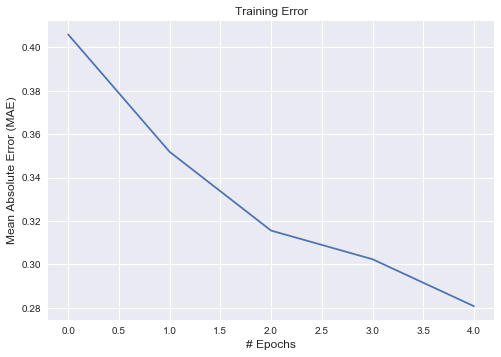

In [54]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(btc_history.epoch, btc_history.history['loss'])
ax1.set_title('Training Error')

if btc_model.loss == 'mae':
    ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
# just in case you decided to change the model loss calculation
else:
    ax1.set_ylabel('Model Loss',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)
plt.show()

### Training Set Performance

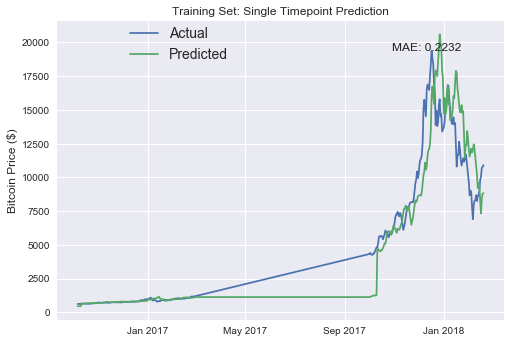

In [55]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,5,9]])
ax1.plot(newdf[newdf['date']< split_date]['date'][window_len:].astype(datetime.datetime),
         training_set['price'][window_len:], label='Actual')
ax1.plot(newdf[newdf['date']< split_date]['date'][window_len:].astype(datetime.datetime),
         ((np.transpose(btc_model.predict(LSTM_training_inputs))+1) * training_set['price'].values[:-window_len])[0], 
         label='Predicted')
ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(btc_model.predict(LSTM_training_inputs))+1)-\
            (training_set['price'].values[window_len:])/(training_set['price'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
# figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset
# axins = zoomed_inset_axes(ax1, 3.35, loc=10) # zoom-factor: 3.35, location: centre
# axins.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
# axins.plot(newdf[newdf['date']< split_date]['date'][window_len:].astype(datetime.datetime),
#         training_set['price'][window_len:], label='Actual')
# axins.plot(newdf[newdf['date']< split_date]['date'][window_len:].astype(datetime.datetime),
#         ((np.transpose(btc_model.predict(LSTM_training_inputs))+1) * training_set['price'].values[:-window_len])[0], 
#         label='Predicted')
# axins.set_xlim([datetime.date(2017, 3, 1), datetime.date(2017, 5, 1)])
# axins.set_ylim([10,60])
# axins.set_xticklabels('')
# mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
plt.show()

### Test set performance
Perhaps not a surprise, but the model didn't do well during the big run-up last year. Although there seems to be something wrong with the coding on this plot.

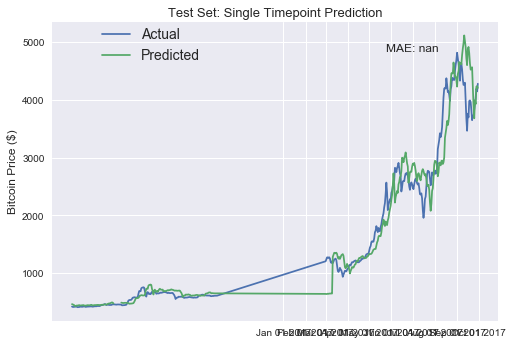

In [57]:
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(newdf[newdf['date']>= split_date]['date'][window_len:].astype(datetime.datetime),
         test_set['price'][window_len:], label='Actual')
ax1.plot(newdf[newdf['date']>= split_date]['date'][window_len:].astype(datetime.datetime),
         ((np.transpose(btc_model.predict(LSTM_test_inputs))+1) * test_set['price'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(btc_model.predict(LSTM_test_inputs))+1)-\
            (test_set['price'].values[window_len:])/(test_set['price'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()